# Static approach

In [63]:
from data_fetching import load_movielens_ratings
import numpy as np
import pandas as pd

df_ratings = load_movielens_ratings()
df_ratings = df_ratings.sort_values(['user_id', 'timestamp'])
df_ratings.head()

,user_id,movie_id,rating,timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


# Loading and Sorting the Ratings Dataset

In this cell, we load the MovieLens ratings dataset using our custom functio `load_movielens_ratings()`. The dataset contains multiple columnn:

- `user_id`: Identifier for users
- `movie_id`: Identifier for movies
- `rating`: Rating given by the user to a particular movie
- `timestamp`: Timestamp for the rating
  
We then sort the dataset by `user_id` and `timestamp`. This sorting serves a twofold purpose:

It helps us maintain the temporal order of ratings, which will be beneficial when we tackle sequential approaches.
It makes it easier to filter out the data based on users, which is essential for our user-based train/test split strategy.

In [64]:
from data_fetching import load_movielens_ratings
import numpy as np
import pandas as pd

df_ratings = load_movielens_ratings()
df_ratings = df_ratings.sort_values(['user_id', 'timestamp'])
df_ratings.head()

,user_id,movie_id,rating,timestamp
31,1,3186,4,978300019
22,1,1270,5,978300055
27,1,1721,4,978300055
37,1,1022,5,978300055
24,1,2340,3,978300103


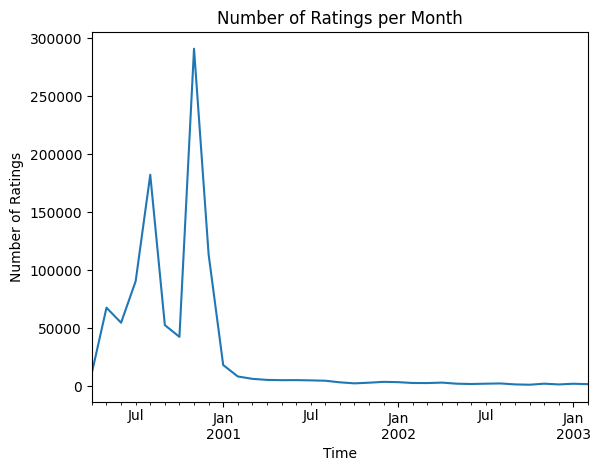

In [65]:
# Visualize ratings to get idea about ratings distribution and time-span
import matplotlib.pyplot as plt

df_ratings['timestamp'] = pd.to_datetime(df_ratings['timestamp'], unit='s')

# Resample data to get counts per month and plot
df_ratings.set_index('timestamp').resample('M').size().plot()
plt.title('Number of Ratings per Month')
plt.xlabel('Time')
plt.ylabel('Number of Ratings')
plt.show()

# Filtering Out Low Ratings

## What We Are Doing
In this cell, we remove all rows where the movie rating is below 3. We accomplish this by using a conditional statement to keep only the rows in the DataFrame where the rating column is greater than or equal to 3.

## Why We Are Doing This
The rationale behind this step is to focus our model on predicting movies that the user is likely to have a positive or at least a neutral sentiment towards. In the context of the MovieLens dataset, a rating of 3 or above can be considered as a marker of a "good" movie recommendation for that particular user.

## Implications
By concentrating only on positive ratings, we are optimizing our model to provide recommendations that are likely to be well-received by the user. This approach helps to mitigate the risk of suggesting movies that the user would dislike, thus enhancing the user experience and the model's utility.

In [66]:
# Filter out rows with ratings below 3
df_ratings = df_ratings[df_ratings['rating'] >= 3]
df_ratings['rating'].value_counts()

rating
4    348971
3    261197
5    226310
Name: count, dtype: int64

# Dropping users with less than 2 ratings

After filtering out the lower ratings (those below 3), we aim to further refine the dataset by dropping users who have fewer than 2 remaining ratings. This step is crucial for a couple of reasons:

Sparsity: With fewer ratings, these users contribute to the sparsity of the user-item interaction matrix. A sparse matrix is not only memory-intensive but also often results in poorer model performance.

Insufficient Data for Masking: Since our task involves masking a movie that a user has rated to serve as the target variable, a user must have rated at least 2 movies for the masking operation to be meaningful. If a user has only rated one movie, then masking that single movie would leave us with no feature variables for that user, which would be problematic for model training.

In [67]:
# Drop users with fewer than 2 ratings
df_ratings = df_ratings.groupby('user_id').filter(lambda x: len(x) >= 2)

-------
Now let us move on to the data processing step: *One-Hot Encoding Movies for Each User*

# What We Are Doing
In this step, we're transforming our dataset into a matrix where rows correspond to unique users, and columns correspond to individual movies. The matrix is filled with binary indicators: 1 if a user has rated the movie with at least a 3, and 0 otherwise.

# Why We Are Doing This
Our objective is to make the data more accessible for machine learning algorithms. We aim to convert the user-movie interactions into a structured format that can be readily fed into various models. By converting the `user_id` and `movie_id` into a matrix form, we're essentially one-hot encoding our categorical variables. This simplification makes it easier for the model to identify patterns and make predictions.

# How It Works
We first initialize a zero-filled matrix with dimensions corresponding to the total number of users and the total number of movies. Then, we iterate through our filtered DataFrame (df_ratings), and for each user-movie interaction, we set the corresponding cell in the matrix to 1.

# What Comes Next
After preparing the movie matrix, we may proceed with masking and creating target variables.

In [68]:
NUM_OF_MOVIES = 3952

# Initialize a matrix filled with zeros
movie_matrix = pd.DataFrame(
    0, 
    index=df_ratings['user_id'].unique(), 
    columns=range(1, NUM_OF_MOVIES + 1)
)
movie_matrix.index.name = 'user_id'

# Fill the matrix based on user's ratings
for index, row in df_ratings.iterrows():
    user_id = row['user_id']
    movie_id = row['movie_id']
    movie_matrix.at[user_id, movie_id] = 1

movie_matrix # notice that two users are completely gone after our preprocessing

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
1,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6037,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6038,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [69]:
# we drop the original dataframe to free up memory
del df_ratings

# Masking and Target Construction
After constructing the movie matrix, where each row corresponds to a user and each column to a specific movie, we proceed to an essential step for training our recommendation model—masking and target creation.

## Why Masking?
In the context of a recommender system, masking serves as a technique to simulate the recommendation scenario. Specifically, we mask one of the movies that the user has rated positively (3 or above). This masked movie serves as the target we aim to predict, effectively simulating the "can we recommend a movie that the user would like?" question.

## How is Masking Done?
For each user, one movie is chosen randomly from the list of movies that they have rated positively and is then set to 0 in the movie matrix. Here, the randomness introduces variability into our training data, which is beneficial for model generalization.

## Target Vector
We create a separate target DataFrame that records the ID of the masked movie for each user. This DataFrame will serve as the 'ground truth' during the training and evaluation of our machine learning model. The target is one-hot encoded, meaning that for each user, we have a vector of length equal to the total number of movies, where all values are set to 0 except for the index corresponding to the masked movie, which is set to 1.

## Caution!
Only movies rated 3 or above are considered for masking. The idea is to ensure that the model learns to recommend movies that are actually liked by the users.

Users with less than two positively rated movies are excluded from this exercise. The rationale here is that we need at least one positively rated movie to serve as feature input and another to serve as the target.

By following this process, we ensure that our model will train on a realistic task, increasing the chances that it will perform well when deployed in a real-world recommendation scenario.

In [70]:
# Initialize a list for storing the target movie IDs
target_movie_ids = []

# For each row, find the indices where the value is 1 (i.e., the user has seen the movie),
# and then randomly choose one to be the target
for idx, row in movie_matrix.iterrows():
    seen_movies = np.where(row == 1)[0]

    target_movie = np.random.choice(seen_movies)
    target_movie_ids.append(target_movie)  # Append to the list
    
    # Mask the selected movie in the original DataFrame
    movie_matrix.loc[idx, movie_matrix.columns[target_movie]] = 0


# Convert list to a numpy array
target_movie_ids = np.array(target_movie_ids, dtype=object)

# Create a one-hot encoded DataFrame for the targets
target_df = pd.DataFrame(
    np.eye(movie_matrix.shape[1], dtype=int)[target_movie_ids.astype(int)],
    columns=movie_matrix.columns,
    index=movie_matrix.index
)


In [75]:
# Identify which movie is the target for each user
target_movies = target_df.idxmax(axis=1)
print(target_movies)

user_id
1       3114
2       1372
3       1270
4       3468
5       2908
        ... 
6036    2085
6037    1221
6038    1210
6039    1237
6040    2692
Length: 6038, dtype: int64


In [80]:
# Loop over the first few users to manually check if masking was done correctly
for user_id, target_movie_id in target_movies.head().items():
    # The value at (user_id, target_movie_id) should be 0, indicating it was masked
    if movie_matrix.loc[user_id, target_movie_id] != 0:
        print(f"Masking failed for user {user_id} and target movie {target_movie_id}")
    else:
        print(f"Masking successful for user {user_id} and target movie {target_movie_id}")

Masking successful for user 1 and target movie 3114
Masking successful for user 2 and target movie 1372
Masking successful for user 3 and target movie 1270
Masking successful for user 4 and target movie 3468
Masking successful for user 5 and target movie 2908


# Data Splitting: Train/Validation/Test Sets
After having prepared the movie matrix and the target matrix, the next pivotal step is to divide our dataset into training, validation, and test sets. The objective here is to create a robust evaluation scheme that mirrors how the model will perform on unseen data.

## Predefined User Splits
In this project, we already have pre-existing files containing user IDs earmarked for each data split (train_users.csv, validation_users.csv, test_users.csv). These files serve as a guideline to segregate the dataset accordingly, ensuring consistency and reproducibility.

## Creating the Splits
Load the User IDs: We first load the predefined user IDs from the respective CSV files.

## Filter DataFrames
Using these user IDs, we filter both the movie and target matrices to create train, validation, and test sets.

By adhering to this method, we ensure that the user data in our train, validation, and test sets are mutually exclusive, which is quintessential for a rigorous model evaluation.

In [85]:
# load predefines splits
train_users = pd.read_csv('data/splits/train_users.csv')
val_users = pd.read_csv('data/splits/val_users.csv')
test_users = pd.read_csv('data/splits/test_users.csv')

# subset accordinly
train_movie_matrix = movie_matrix[movie_matrix.index.isin(train_users['user_id'])]
val_movie_matrix = movie_matrix[movie_matrix.index.isin(val_users['user_id'])]
test_movie_matrix = movie_matrix[movie_matrix.index.isin(test_users['user_id'])]

train_target_matrix = target_df[target_df.index.isin(train_users['user_id'])]
val_target_matrix = target_df[target_df.index.isin(val_users['user_id'])]
test_target_matrix = target_df[target_df.index.isin(test_users['user_id'])]


In [86]:
test_target_matrix

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [88]:
test_movie_matrix.shape

(1208, 3952)

# First modelling steps

In [90]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split

# Assume X is your feature matrix and y is your target vector
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train = train_movie_matrix
y_train = train_target_matrix

X_test = test_movie_matrix
y_test = test_target_matrix

# Create a decision tree classifier
decision_tree_classifier = DecisionTreeClassifier(random_state=42)

# Wrap the classifier with MultiOutputClassifier
multi_target_classifier = MultiOutputClassifier(decision_tree_classifier, n_jobs=-1)

# Train the classifier
multi_target_classifier.fit(X_train, y_train)

# Predict the labels
y_pred = multi_target_classifier.predict(X_test)

# Evaluate the classifier
print(f"Accuracy score: {accuracy_score(y_test, y_pred)}")


Accuracy score: 0.0008278145695364238


In [91]:
y_test

,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
user_id,,,,,,,,,,,,,,,,,,,,,
16,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
18,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
24,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
26,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
27,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6006,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6008,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6030,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [92]:
y_pred

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])